In [1]:
# !pip install PyPortfolioOpt

In [2]:
# 필요한 라이브러리들을 불러옵니다.
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# 포트폴리오 최적화를 위한 PyPortfolioOpt 라이브러리
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting

# 데이터프레임 출력 옵션 설정
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# --- 설정값 ---
INPUT_FILENAME = "top_50_zscore_rank_3Y.csv"
# ---

try:
    top_50_df = pd.read_csv(INPUT_FILENAME)
    tickers = top_50_df['Ticker'].tolist()
    tickers = list(set(tickers))

    print(f"✅ '{INPUT_FILENAME}'에서 상위 {len(tickers)}개 티커를 불러왔습니다.")
    print(tickers)
except FileNotFoundError:
    print(f"❌ 오류: '{INPUT_FILENAME}' 파일을 찾을 수 없습니다. 이전 단계를 먼저 실행해주세요.")
    tickers = []



✅ 'top_50_zscore_rank_3Y.csv'에서 상위 50개 티커를 불러왔습니다.
['RKLB', 'SLNO', 'HRTG', 'HIMS', 'PPTA', 'AAOI', 'MFH', 'PSIX', 'IREN', 'VRT', 'MAMA', 'SMMT', 'MOD', 'INOD', 'CLS', 'POWL', 'RGTI', 'PLTR', 'ZEPP', 'FTAI', 'CRDO', 'IESC', 'RYTM', 'LMB', 'MSTR', 'QURE', 'UAMY', 'SKYX', 'DAVE', 'TMQ', 'AMSC', 'STRL', 'CIFR', 'APLD', 'TSSI', 'ACIC', 'IONQ', 'IAG', 'COSM', 'CVNA', 'DRUG', 'TPC', 'HCA', 'STKE', 'ABBV', 'ASTS', 'FEIM', 'ROOT', 'HOOD', 'APP']


In [3]:
# if tickers:
#     # 데이터 수집 기간 설정 (오늘부터 3년 전까지)
#     end_date = datetime.today()
#     start_date = end_date - timedelta(days=3*365)
    
#     print(f"\n✅ 데이터 수집 기간: {start_date.strftime('%Y-%m-%d')} ~ {end_date.strftime('%Y-%m-%d')}")
    
#     # yfinance를 통해 50개 종목의 수정 종가 데이터를 다운로드합니다.
#     prices = yf.download(tickers, start=start_date, end=end_date)['Adj Close'].dropna(how="all")
#     print("\n✅ 주가 데이터 수집 완료!")
#     display(prices.head())

In [4]:
if tickers:
    # 데이터 수집 기간 설정
    end_date = datetime.today()
    start_date = end_date - timedelta(days=3*365)
    
    print(f"\n✅ 데이터 수집 기간: {start_date.strftime('%Y-%m-%d')} ~ {end_date.strftime('%Y-%m-%d')}")
    
    # yfinance를 통해 전체 데이터를 다운로드합니다.
    # 최신 버전에서는 auto_adjust=True가 기본값이므로 'Adj Close'가 아닌 'Close'를 사용합니다.
    data = yf.download(tickers, start=start_date, end=end_date)
    
    # 'Close' 컬럼만 선택합니다. (이것이 이제 수정 종가입니다)
    if isinstance(data.columns, pd.MultiIndex):
        prices = data['Close'] # 이 부분을 수정
    else:
        prices = data[['Close']] # 이 부분도 수정

    prices = prices.dropna(how="all")
    
    print("\n✅ 주가 데이터 수집 완료!")
    display(prices.head())




✅ 데이터 수집 기간: 2022-10-25 ~ 2025-10-24


/tmp/ipykernel_206670/3381222765.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  50 of 50 completed



✅ 주가 데이터 수집 완료!


Ticker,AAOI,ABBV,ACIC,AMSC,APLD,APP,ASTS,CIFR,CLS,COSM,CRDO,CVNA,DAVE,DRUG,FEIM,FTAI,HCA,HIMS,HOOD,HRTG,IAG,IESC,INOD,IONQ,IREN,LMB,MAMA,MFH,MOD,MSTR,PLTR,POWL,PPTA,PSIX,QURE,RGTI,RKLB,ROOT,RYTM,SKYX,SLNO,SMMT,STKE,STRL,TMQ,TPC,TSSI,UAMY,VRT,ZEPP
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-10-26,2.89,136.640793,0.404398,4.44,2.20,17.990000,6.14,1.18,10.88,0.112,13.16,15.10,10.336,5.10,3.962155,14.893434,212.069946,4.43,11.08,1.45,1.51,33.119999,3.51,5.53,3.605,8.15,1.040,0.933333,16.420000,27.271999,8.57,23.416065,1.77,1.82,18.910000,2.10,4.69,7.51,24.690001,3.67,1.250,1.07,0.368,26.549999,0.57,6.90,0.60,0.36,14.548033,4.92
2022-10-27,2.81,137.527802,0.404398,4.27,2.20,17.580000,5.91,1.10,10.77,0.094,13.38,14.52,9.920,4.90,4.017625,15.180560,212.352707,4.34,11.16,1.42,1.44,33.189999,3.52,5.47,3.380,7.94,1.090,0.933333,16.860001,27.056000,8.60,22.442808,1.78,2.00,18.120001,2.13,4.79,7.42,25.580000,3.61,1.135,1.12,0.384,26.780001,0.56,7.01,0.60,0.40,14.737356,4.96
2022-10-28,2.80,132.250671,0.385141,4.27,2.22,17.389999,6.52,1.15,11.06,0.087,13.72,14.49,9.760,4.93,4.239505,16.319796,218.096207,4.49,11.50,1.46,1.44,34.250000,3.26,5.69,3.470,8.08,1.031,0.955556,17.770000,27.999001,8.64,23.734068,2.10,2.00,19.040001,2.09,5.13,7.78,26.370001,3.53,1.050,1.10,0.384,27.250000,0.56,7.36,0.60,0.38,14.906752,5.08
2022-10-31,2.75,131.166595,0.394770,4.52,2.25,16.959999,7.23,1.01,10.96,0.085,13.74,13.53,10.048,4.95,4.081019,16.097504,212.060181,4.54,11.68,1.50,1.46,33.040001,3.31,5.89,3.385,8.32,1.030,0.955556,17.920000,26.750999,8.79,23.772610,2.35,2.00,18.620001,2.10,5.09,8.53,25.170000,3.38,0.990,1.09,0.320,26.990000,0.56,7.42,0.60,0.38,14.259065,4.92
2022-11-01,2.73,131.623535,0.394770,4.74,2.29,17.120001,6.87,1.01,11.07,0.084,13.91,15.28,10.112,4.95,4.160262,16.319796,215.629135,4.52,11.92,1.73,1.49,33.900002,3.27,5.61,3.390,8.42,1.090,0.936667,18.190001,25.719999,8.65,24.235147,2.31,2.00,18.840000,1.88,5.20,8.07,26.180000,3.15,0.990,1.08,0.480,29.930000,0.58,7.46,0.59,0.39,14.787178,5.20


In [5]:
if not prices.empty:
    # 1. 연간 기대수익률 계산 (과거 데이터 기반)
    mu = expected_returns.mean_historical_return(prices)
    # mu = expected_returns.ema_historical_return(prices)
    
    # 2. 연간 공분산 행렬 계산 (위험 모델)
    S = risk_models.sample_cov(prices)
    
    print("✅ 연간 기대수익률 (mu):")
    display(mu.head())
    print("\n✅ 연간 공분산 행렬 (S):")
    display(S.head())

✅ 연간 기대수익률 (mu):


Ticker
AAOI    1.228983
ABBV    0.188149
ACIC    2.112630
AMSC    1.350959
APLD    1.493661
dtype: float64


✅ 연간 공분산 행렬 (S):


Ticker,AAOI,ABBV,ACIC,AMSC,APLD,APP,ASTS,CIFR,CLS,COSM,CRDO,CVNA,DAVE,DRUG,FEIM,FTAI,HCA,HIMS,HOOD,HRTG,IAG,IESC,INOD,IONQ,IREN,LMB,MAMA,MFH,MOD,MSTR,PLTR,POWL,PPTA,PSIX,QURE,RGTI,RKLB,ROOT,RYTM,SKYX,SLNO,SMMT,STKE,STRL,TMQ,TPC,TSSI,UAMY,VRT,ZEPP
Ticker,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AAOI,1.543217,0.003584,0.053163,0.388209,0.355374,0.305446,0.296825,0.446437,0.260213,0.349608,0.336285,0.347781,0.256278,-0.238290,0.105642,0.161928,0.018200,0.231090,0.267238,0.067794,0.096479,0.247316,0.444655,0.391087,0.394063,0.174216,0.048368,0.070292,0.241786,0.275191,0.261986,0.168742,0.068829,0.180774,0.114506,0.434428,0.229053,0.091231,0.126954,0.189119,0.104043,0.089120,0.315373,0.177781,0.069744,0.131142,0.250458,0.148104,0.285096,0.187110
ABBV,0.003584,0.052301,0.003118,0.002609,-0.010610,0.006714,0.006747,0.005897,0.001001,-0.375310,-0.002178,-0.009910,0.008266,-0.035169,-0.001449,0.008760,0.010845,0.005810,0.007066,0.009031,0.007190,0.001806,-0.004739,0.002624,-0.015740,0.001133,0.004882,-0.028009,-0.001943,-0.013213,0.008320,-0.000411,0.003783,0.001105,0.007967,0.003967,0.003647,0.010285,0.019433,0.006928,0.006106,0.029046,-0.016061,-0.003003,0.007346,-0.001726,0.019075,0.010617,-0.002697,0.010596
ACIC,0.053163,0.003118,1.113678,0.098119,0.187183,0.032738,0.042908,0.116301,0.025892,0.297100,-0.012719,0.057031,0.066870,-0.003845,0.015245,0.026137,0.018384,0.013037,0.040139,0.187088,0.044667,0.059540,0.091961,0.089023,0.057885,0.052632,0.097400,0.037736,0.014119,0.048937,0.054343,0.054181,0.053712,0.071937,0.053147,0.059729,0.049296,0.025735,0.066259,0.094852,-0.090208,-0.003392,-0.045769,0.039949,0.041963,0.017608,0.060989,0.019323,0.010284,0.005559
AMSC,0.388209,0.002609,0.098119,0.866605,0.308473,0.181373,0.243506,0.280645,0.150477,-0.610716,0.201525,0.323225,0.191061,-0.076472,0.087145,0.115400,0.020597,0.189761,0.185267,0.091985,0.080505,0.184822,0.336565,0.284131,0.295242,0.161511,0.052485,0.109320,0.179129,0.240926,0.186224,0.105717,0.104508,0.100120,0.096497,0.361294,0.224714,0.175927,0.177931,0.178010,0.026049,0.193504,0.106209,0.159520,0.059880,0.167868,0.194913,0.106071,0.156156,0.089884
APLD,0.355374,-0.010610,0.187183,0.308473,1.688747,0.199584,0.262737,0.568844,0.157143,-0.005885,0.207926,0.310718,0.175166,-0.051271,0.059719,0.096522,0.004278,0.183543,0.248246,0.059758,0.107415,0.147489,0.292077,0.382746,0.488872,0.162956,0.088922,0.160213,0.193444,0.313062,0.217259,0.159708,0.194245,0.123910,-0.007509,0.393586,0.234053,0.156784,0.103168,0.127293,0.114790,0.035353,-0.005987,0.155849,0.182320,0.150000,0.321508,0.188496,0.196560,0.108329


/data/anaconda3/envs/st_py311/lib/python3.11/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


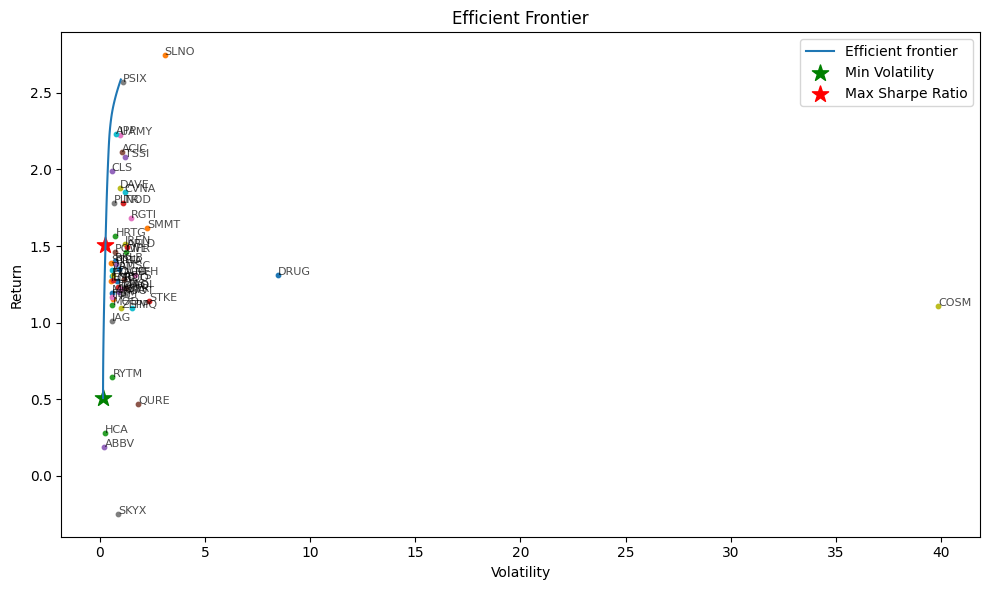


--- 최소 변동성 포트폴리오 ---
기대수익률: 50.75%, 변동성(리스크): 16.02%

--- 최대 샤프 지수 포트폴리오 ---
기대수익률: 150.80%, 변동성(리스크): 27.65%


In [6]:

# 'mu'와 'S'는 이미 계산되었다고 가정합니다.
if 'mu' in locals() and 'S' in locals():
    
    # 1. 최소 변동성 포트폴리오 계산
    # 객체를 새로 생성합니다.
    ef_min_vol = EfficientFrontier(mu, S)
    min_vol_weights = ef_min_vol.min_volatility()
    min_vol_ret, min_vol_risk, _ = ef_min_vol.portfolio_performance()
    
    # 2. 최대 샤프 지수 포트폴리오 계산
    # 객체를 다시 새로 생성합니다.
    ef_max_sharpe = EfficientFrontier(mu, S)
    max_sharpe_weights = ef_max_sharpe.max_sharpe()
    max_sharpe_ret, max_sharpe_risk, _ = ef_max_sharpe.portfolio_performance()

    # 3. 시각화 (효율적 투자선은 한 번만 계산)
    ef_for_plotting = EfficientFrontier(mu, S)
    fig, ax = plt.subplots(figsize=(10, 6))
    plotting.plot_efficient_frontier(ef_for_plotting, ax=ax, show_assets=False)
    
    # 계산된 포트폴리오 결과 플로팅
    ax.scatter(min_vol_risk, min_vol_ret, marker="*", color="g", s=150, label="Min Volatility")
    ax.scatter(max_sharpe_risk, max_sharpe_ret, marker="*", color="r", s=150, label="Max Sharpe Ratio")

    # # 각 포트폴리오의 티커별 위치 표시
    for ticker in tickers:
        ret = mu[ticker]
        risk = np.sqrt(S.loc[ticker, ticker])
        ax.scatter(risk, ret, marker="o", s=10)
        ax.text(risk, ret, ticker, fontsize=8, alpha=0.7)
    

    # 그래프 스타일 설정
    ax.set_title("Efficient Frontier")
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    print("\n--- 최소 변동성 포트폴리오 ---")
    print(f"기대수익률: {min_vol_ret:.2%}, 변동성(리스크): {min_vol_risk:.2%}")
    
    print("\n--- 최대 샤프 지수 포트폴리오 ---")
    print(f"기대수익률: {max_sharpe_ret:.2%}, 변동성(리스크): {max_sharpe_risk:.2%}")

In [7]:
def print_weights(weights):
    """가중치를 깔끔하게 출력하는 함수"""
    weights_series = pd.Series(weights)
    # 가중치가 0.1% 이상인 종목만 출력
    print(weights_series[weights_series > 0.001].sort_values(ascending=False).to_string())

if 'ef' in locals():
    # 리스크 범위를 정의합니다 (최소 변동성 ~ 최대 샤프 지수)
    min_risk_level = min_vol_risk
    max_risk_level = max_sharpe_risk
    risk_range = max_risk_level - min_risk_level
    
    # 목표 리스크 수준을 퍼센트로 정의
    target_risk_percentages = [0.60, 0.65, 0.70, 0.80, 0.90, 1.00]
    
    print("\n" + "="*50)
    print("           특정 리스크 수준별 포트폴리오 가중치")
    print("="*50 + "\n")
    
    for p in target_risk_percentages:
        # 목표 변동성(리스크) 값을 계산
        target_risk = min_risk_level + risk_range * p
        
        print(f"--- 리스크 수준: {p:.0%} (목표 변동성: {target_risk:.2%}) ---")
        
        try:
            # 해당 목표 리스크를 달성하는 포트폴리오를 계산
            ef_target_risk = EfficientFrontier(mu, S)

            target_weights = ef_target_risk.efficient_risk(target_volatility=target_risk)
            
            # 가중치 출력
            print_weights(target_weights)
            print("\n" + "-"*50 + "\n")
            
        except Exception as e:
            print(f"해당 리스크 수준의 포트폴리오를 계산할 수 없습니다: {e}\n")

In [8]:
import json # JSON 라이브러리 추가

def print_weights(weights):
    """가중치를 깔끔하게 출력하는 함수"""
    weights_series = pd.Series(weights)
    # 가중치가 0.1% 이상인 종목만 출력
    print(weights_series[weights_series > 0.001].sort_values(ascending=False).to_string())

if 'ef' in locals():
    # 리스크 범위를 정의합니다 (최소 변동성 ~ 최대 샤프 지수)
    min_risk_level = min_vol_risk
    max_risk_level = max_sharpe_risk
    risk_range = max_risk_level - min_risk_level
    
    # 목표 리스크 수준을 퍼센트로 정의
    target_risk_percentages = [0.60, 0.65, 0.70, 0.80, 0.90, 1.00]
    
    print("\n" + "="*50)
    print("           특정 리스크 수준별 포트폴리오 가중치")
    print("="*50 + "\n")
    
    for p in target_risk_percentages:
        # 목표 변동성(리스크) 값을 계산
        target_risk = min_risk_level + risk_range * p
        
        print(f"--- 리스크 수준: {p:.0%} (목표 변동성: {target_risk:.2%}) ---")
        
        try:
            # 해당 목표 리스크를 달성하는 포트폴리오를 계산
            ef_target_risk = EfficientFrontier(mu, S)

            target_weights = ef_target_risk.efficient_risk(target_volatility=target_risk)
            
            # 가중치 출력
            print_weights(target_weights)

            # 📌 추가된 부분: p가 0.65일 때 JSON 파일로 저장
            if p == 0.65:
                # 가중치가 0.1% 이상인 종목만 필터링하여 새로운 딕셔너리 생성
                weights_to_save = {ticker: weight for ticker, weight in target_weights.items() if weight > 0.001}
                
                output_json_filename = 'portfolio_weights_65_risk.json'
                with open(output_json_filename, 'w', encoding='utf-8') as f:
                    json.dump(weights_to_save, f, ensure_ascii=False, indent=4)
                
                print(f"\n  ✨ 65% 리스크 포트폴리오가 '{output_json_filename}' 파일로 저장되었습니다.")

            print("\n" + "-"*50 + "\n")
            
        except Exception as e:
            print(f"해당 리스크 수준의 포트폴리오를 계산할 수 없습니다: {e}\n")

In [9]:

# 맥스 샤프 비율 포트폴리오 가중치를 JSON 파일로 저장
if 'max_sharpe_weights' in locals():
    # 가중치가 0.1% 이상인 종목만 필터링
    filtered_weights = {ticker: weight for ticker, weight in max_sharpe_weights.items() if weight > 0.001}
    
    # JSON 파일로 저장
    output_json_filename = 'portfolio_weights_max_sharpe.json'
    with open(output_json_filename, 'w', encoding='utf-8') as f:
        json.dump(filtered_weights, f, ensure_ascii=False, indent=4)
    
    print(f"\n✅ 맥스 샤프 비율 포트폴리오 가중치가 '{output_json_filename}' 파일로 저장되었습니다.")
    print(f"   - 종목 수: {len(filtered_weights)}")
    print(f"   - 가중치 합계: {sum(filtered_weights.values()):.4f}")


✅ 맥스 샤프 비율 포트폴리오 가중치가 'portfolio_weights_max_sharpe.json' 파일로 저장되었습니다.
   - 종목 수: 21
   - 가중치 합계: 0.9993


In [10]:
input_filename = 'portfolio_weights_max_sharpe.json'
try:
    with open(input_filename, 'r', encoding='utf-8') as f:
        weights = json.load(f)
    
    # 현재 가중치 합계 계산
    current_sum = sum(weights.values())
    
    # 기존 가중치를 조정하여 총합이 0.6이 되도록 스케일링
    M_V = 0.7

    # 모든 가중치를 소수점 자리까지 반올림
    scaling_factor = 1-M_V / current_sum
    scaled_weights = {ticker: weight * scaling_factor for ticker, weight in weights.items()}
    rounded_weights = {ticker: round(weight, 3) for ticker, weight in scaled_weights.items()}

    # MONEY 티커 추가 (비중 0.4)
    scaled_weights['MONEY'] = M_V

    # 라운딩으로 인한 오차를 보정하여 정확히 합계가 1이 되도록 조정
    total_after_rounding = sum(rounded_weights.values())
    if total_after_rounding != 1.00:
        # 가장 큰 가중치를 가진 티커에 오차를 더하거나 빼서 합계를 1로 맞춤
        max_ticker = max(rounded_weights.items(), key=lambda x: x[1] if x[0] != 'MONEY' else 0)[0]
        rounded_weights[max_ticker] = round(rounded_weights[max_ticker] + (1.00 - total_after_rounding), 3)
    
    # 최종 포트폴리오 가중치를 JSON 파일로 저장
    output_filename = 'final_portfolio_weights.json'
    with open(output_filename, 'w', encoding='utf-8') as f:
        json.dump(rounded_weights, f, ensure_ascii=False, indent=4)
    
    print(f"\n✅ 최종 포트폴리오 가중치가 '{output_filename}' 파일로 저장되었습니다.")
    print(f"   - MONEY 비중: {rounded_weights.get('MONEY', 0):.3f}")
    print(f"   - 기타 자산 비중 총합: {sum(rounded_weights.values()) - rounded_weights.get('MONEY', 0):.3f}")
    print(f"   - 전체 비중 총합: {sum(rounded_weights.values()):.3f}")
    
except FileNotFoundError:
    print(f"❌ 오류: '{input_filename}' 파일을 찾을 수 없습니다. 이전 단계를 먼저 실행해주세요.")
except Exception as e:
    print(f"❌ 오류 발생: {str(e)}")


✅ 최종 포트폴리오 가중치가 'final_portfolio_weights.json' 파일로 저장되었습니다.
   - MONEY 비중: 0.000
   - 기타 자산 비중 총합: 1.000
   - 전체 비중 총합: 1.000


In [11]:
import json

# --- 설정 ---
# 1. 최대 샤프 지수 가중치가 저장된 JSON 파일 경로
max_sharpe_weights_path = r'final_portfolio_weights.json'
# 2. 최종 포트폴리오를 저장할 파일 경로 (선택 사항)
final_portfolio_path = r'final_portfolio_with_cash.json'

# 3. 고정할 현금(MONEY) 비중
CASH_WEIGHT = 0.8
# 4. 나머지 자산에 할당될 비중
EQUITY_WEIGHT = 1 - CASH_WEIGHT

# --- 로직 ---
# 기존 포트폴리오 가중치 로드
with open(max_sharpe_weights_path, 'r', encoding='utf-8') as f:
    original_weights = json.load(f)

# 새로운 가중치를 계산할 딕셔너리 생성
adjusted_weights = {}

# 각 자산의 가중치를 남은 비중(0.6)에 맞춰 재계산하고 소수점 3자리에서 반올림
for ticker, weight in original_weights.items():
    adjusted_weights[ticker] = round(weight * EQUITY_WEIGHT, 3)

# 소수점 3자리에서 0.000인 항목 제거
adjusted_weights = {k: v for k, v in adjusted_weights.items() if v != 0.000}

# 반올림 후 MONEY를 제외한 나머지의 합계 계산
equity_sum = sum(adjusted_weights.values())

# MONEY를 제외한 나머지의 합이 정확히 0.6이 되도록 조정
if equity_sum != EQUITY_WEIGHT:
    # 가장 큰 가중치를 가진 자산에 오차를 보정
    difference = round(EQUITY_WEIGHT - equity_sum, 3)
    max_ticker = max(adjusted_weights.items(), key=lambda x: x[1])[0]
    adjusted_weights[max_ticker] = round(adjusted_weights[max_ticker] + difference, 3)

# 현금 비중 추가
adjusted_weights['MONEY'] = CASH_WEIGHT

# --- 결과 확인 ---
print(f"✅ 현금 비중 {CASH_WEIGHT}를 적용하여 포트폴리오 가중치를 재조정했습니다.")
print("\n--- 최종 조정된 포트폴리오 가중치 ---")

# 보기 좋게 정렬하여 출력
for ticker, weight in sorted(adjusted_weights.items()):
    print(f"- {ticker:<6}: {weight:.3f}")

print("---------------------------------------")
# MONEY를 제외한 자산들의 합계와 전체 합계 검증
equity_total = sum(v for k, v in adjusted_weights.items() if k != 'MONEY')
total_weight = sum(adjusted_weights.values())
print(f"📊 MONEY 제외 총 가중치: {equity_total:.3f}")
print(f"📊 전체 가중치 합계: {total_weight:.3f}")


# --- 파일 저장 (필요시 주석 해제) ---
with open(final_portfolio_path, 'w', encoding='utf-8') as f:
    json.dump(adjusted_weights, f, indent=4)
print(f"\n✅ 조정된 포트폴리오를 '{final_portfolio_path}' 파일에 저장했습니다.")


✅ 현금 비중 0.8를 적용하여 포트폴리오 가중치를 재조정했습니다.

--- 최종 조정된 포트폴리오 가중치 ---
- ABBV  : 0.006
- ACIC  : 0.003
- APP   : 0.004
- CLS   : 0.149
- DAVE  : 0.001
- FEIM  : 0.006
- FTAI  : 0.003
- HCA   : 0.002
- HRTG  : 0.004
- IAG   : 0.002
- MAMA  : 0.006
- MFH   : 0.001
- MONEY : 0.800
- PLTR  : 0.001
- POWL  : 0.001
- PPTA  : 0.001
- PSIX  : 0.003
- SLNO  : 0.001
- TSSI  : 0.001
- UAMY  : 0.003
- ZEPP  : 0.002
---------------------------------------
📊 MONEY 제외 총 가중치: 0.200
📊 전체 가중치 합계: 1.000

✅ 조정된 포트폴리오를 'final_portfolio_with_cash.json' 파일에 저장했습니다.
